In [35]:
import os, re
import pandas as pd
from prody import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_data = '/opt/experiments/pep_hla_dynamics/md_sims/'

In [ ]:
# Traverse through folder hierarchy in root_data and collect all folder paths in a list.
all_folders = []
for dirpath, dirnames, filenames in os.walk(root_data):
    all_folders.append(dirpath)

In [30]:
# Extract peptide codes (first three aas), HLA gene, HLA_allele, and replicate number from each folder path using regex.
# Example: /opt/experiments/pep_hla_dynamics/md_sims/AII_C_14_02_3
pattern = re.compile(r'.*/([A-Z]{3})_([A-Z])_(\d{2}_\d{2})_(\d+)')
extracted_info = []
for folder in all_folders:
    match = pattern.match(folder)
    if match:
        peptide_code = match.group(1)
        hla_gene = match.group(2)
        hla_allele = hla_gene+'_'+match.group(3)
        replicate_number = match.group(4)
        extracted_info.append((folder, peptide_code.upper(), hla_gene, hla_allele, replicate_number))

In [31]:
# Create a DataFrame from the extracted information.
df_metadata = pd.DataFrame(extracted_info, columns=['folder_path', 'peptide_code', 'hla_gene', 'hla_allele', 'replicate_number'])

In [32]:
# Scan each folder_path in df_metadata for .dcd files, load the corresponding .pdb file (protein.pdb) using ProDy, 
# and load the trajectory (md_0_250ns_nohmr_dry_center_protein_fit.dcd) onto this using parseDCD.
trajectories = []
for index, row in df_metadata.iterrows():
    folder_path = row['folder_path']
    pdb_file = os.path.join(folder_path, 'protein.pdb')
    dcd_file = os.path.join(folder_path, 'md_0_250ns_nohmr_dry_center_protein_fit.dcd')
    if os.path.exists(pdb_file) and os.path.exists(dcd_file):
        structure = parsePDB(pdb_file)
        trajectory = parseDCD(dcd_file)
        trajectory.setAtoms(structure)
        trajectory.setCoords(trajectory[0])  # Set initial coordinates
        trajectories.append((row['peptide_code'], row['hla_allele'], row['replicate_number'], trajectory))

# Convert the list of trajectories into a DataFrame for easier handling.
df_trajectories = pd.DataFrame(trajectories, columns=['peptide_code', 'hla_allele', 'replicate_number', 'trajectory'])

@> 6087 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 25001 coordinate sets for 6087 atoms.


@> DCD file was parsed in 2.03 seconds.
@> 1743.48 MB parsed at input rate 860.91 MB/s.
@> 25001 coordinate sets parsed at input rate 12345 frame/s.
@> 6087 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 25001 coordinate sets for 6087 atoms.
@> DCD file was parsed in 1.94 seconds.
@> 1743.48 MB parsed at input rate 896.44 MB/s.
@> 25001 coordinate sets parsed at input rate 12854 frame/s.
@> 6089 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 25001 coordinate sets for 6089 atoms.
@> DCD file was parsed in 2.88 seconds.
@> 1744.05 MB parsed at input rate 606.56 MB/s.
@> 25001 coordinate sets parsed at input rate 8694 frame/s.
@> 6089 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> DCD file contains 25001 coordinate sets for 6089 atoms.
@> DCD file was parsed in 2.66 seconds.
@> 1744.05 MB parsed at input rate 655.96 MB/s.
@> 25001 coordinate sets parsed at input rate 9403 frame/s.
@> 6089 atoms and 1 coordinate set(s) were parsed

In [33]:
# Create RMSD time profiles (no superposition needed), taking the first frame of each trajectory as reference, 
# and store them in a new DataFrame.
rmsd_profiles = []
for index, row in df_trajectories.iterrows():
    trajectory = row['trajectory']
    reference_coords = trajectory[0].getCoords()
    rmsd_values = [calcRMSD(reference_coords, trajectory[i].getCoords()) for i in range(len(trajectory))]
    # Create a DataFrame for the RMSD profile.
    rmsd_profile_df = pd.DataFrame({'frame': range(len(trajectory)), 'rmsd': rmsd_values})
    rmsd_profile_df['peptide_code'] = row['peptide_code']
    rmsd_profile_df['hla_allele'] = row['hla_allele']
    rmsd_profile_df['replicate_number'] = row['replicate_number']
    rmsd_profiles.append(rmsd_profile_df)

# Convert the list of RMSD profiles into a DataFrame for easier handling.
df_rmsd_profiles = pd.concat(rmsd_profiles, ignore_index=True)

In [45]:
subset['replicate_number'].unique()

array(['2', '3', '1'], dtype=object)

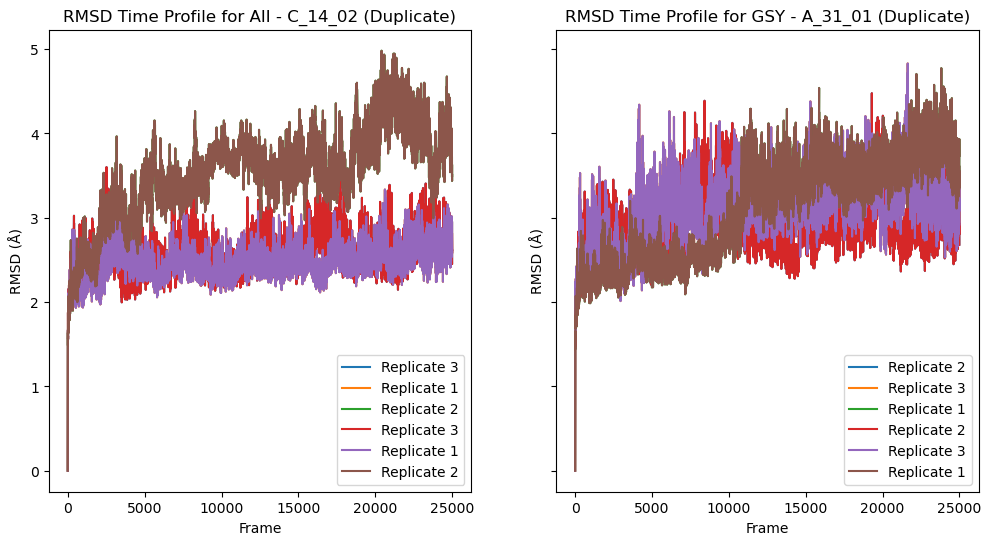

In [46]:
systems = df_rmsd_profiles[['peptide_code', 'hla_allele']].drop_duplicates().values
num_systems = len(systems)
fig, axes = plt.subplots(nrows=1, ncols=num_systems, figsize=(12, 3 * num_systems), sharey=True)
for i, (peptide_code, hla_allele) in enumerate(systems):
    ax1 = axes[i]
    ax2 = axes[i]
    subset = df_rmsd_profiles[(df_rmsd_profiles['peptide_code'] == peptide_code) & (df_rmsd_profiles['hla_allele'] == hla_allele)]
    for replicate_number in subset['replicate_number'].unique():
        replicate_data = subset[subset['replicate_number'] == replicate_number]
        ax1.plot(replicate_data['frame'], replicate_data['rmsd'], label=f'Replicate {replicate_number}')
    ax1.set_title(f'RMSD Time Profile for {peptide_code} - {hla_allele}')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('RMSD (Å)')
    ax1.legend()
    
    # For the second column, we can plot the same data or any other relevant data.
    for replicate_number in subset['replicate_number'].unique():
        replicate_data = subset[subset['replicate_number'] == replicate_number]
        ax2.plot(replicate_data['frame'], replicate_data['rmsd'], label=f'Replicate {replicate_number}')
    ax2.set_title(f'RMSD Time Profile for {peptide_code} - {hla_allele} (Duplicate)')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('RMSD (Å)')
    ax2.legend()